# Comparing proxies for TAS diagram with other methods

Here, proxies for SiO2 and Na2O+K2O are calculated using SVM regressor using parameters obtained in previous Notebooks. Results are plotted to estimate the success of the prediction.

In [1]:
%load_ext watermark
%watermark -a 'Antoine' -i -v -m -p pandas,numpy,matplotlib,sklearn

Antoine 2017-06-26T11:36:44-04:00

CPython 3.5.3
IPython 5.1.0

pandas 0.19.2
numpy 1.11.3
matplotlib 1.5.1
sklearn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [2]:
%matplotlib inline

import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

from PIL import Image

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

## 1) Opening dataset and QA/QC

The dataset has been previously cleaned by Sarane. Only rock analysis are included, and samples are unaltered.

In [3]:
xl_file = pd.ExcelFile('sub_alcaline_dataset_GeoRock.xlsx')
dfs = {sheet_name: xl_file.parse(sheet_name) for sheet_name in xl_file.sheet_names}
sheet_names = list(dfs.keys())
df = dfs[sheet_names[0]]

######### Removing columns with too many missing data
a = df.iloc[:, 15:91].count(axis=0)
a = len(df.index) - a
a[a!=0]
df.drop(a[a>50].index.values, axis=1, inplace=True)
######## Removing samples with missing data
df.dropna(subset=a[a<=50].index.values, inplace=True)

######## Drop all useless columns
df.drop(df.iloc[:, 35:].columns.values, axis=1, inplace=True)

######## Removing all lines with values <= 0
df = df[~(df.iloc[:, 15:] <= 0).any(axis=1)]

print ('Shape of the df dataset after transformation:' + str(df.shape))
df.head()

Shape of the df dataset after transformation:(2246, 35)


,Filename,Year,CITATION,SAMPLE NAME,num sample,LOCATION,LAND/SEA (SAMPLING),ROCK TYPE,ROCK NAME,ROCK TEXTURE,SAMPLE COMMENT,"LATITUDE (MIN,)","LONGITUDE (MIN,)","LATITUDE (MAX,)","LONGITUDE (MAX,)",SIO2(WT%),TIO2(WT%),AL2O3(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),BA(PPM),LA(PPM),CE(PPM),SM(PPM),EU(PPM),YB(PPM),TH(PPM)
0,C:\Documents and Settings\Administrator\Deskto...,2003.0,"[10333] KELLEY KATHERINE A,(2003) [GeoRem305]","samp, 185-1149D-11R-2-86-92",1.0,IZU-BONIN ARC / NADEZHDA BASIN / SITE 1149 / P...,SUBAQUATIC,VOLCANIC ROCK,BASALT,NaN,BRECCIA WITH CALCITE CEMENT,31.3132,143.4004,31.3132,143.4004,33.740000,1.170000,10.29000,37.910000,5.460000,0.319000,0.561000,2.210000,0.122000,152.00000,45.900000,79.100000,1.990000,34.500000,4.780000,7.260000,3.4700,1.200000,3.980000,0.117000
1,C:\Documents and Settings\Administrator\Deskto...,2003.0,"[10333] KELLEY KATHERINE A,(2003) [GeoRem305]","samp, 185-1149B-30R-1-61-66",2.0,IZU-BONIN ARC / NADEZHDA BASIN / SITE 1149 / P...,SUBAQUATIC,VOLCANIC ROCK,BASALT,NaN,BRECCIA WITH CALCITE CEMENT,31.3422,143.3510,31.3422,143.3510,37.310000,1.100000,9.86000,31.130000,7.310000,0.119000,1.190000,1.640000,0.113000,141.00000,32.200000,70.400000,1.730000,36.900000,2.250000,7.560000,2.3300,0.777000,2.610000,0.095000
2,C:\Documents and Settings\Administrator\Deskto...,2012.0,"[16063] ICHIYAMA Y, (2012)","samp, INO-R03",3.0,KURILE ARC / KURILE ARC / HOKKAIDO / KAMUIKOTA...,SUBAERIAL,VOLCANIC ROCK,PICRITE,NaN,NaN,NaN,NaN,43.5200,142.3000,40.020000,0.440000,5.61000,5.810000,29.040000,0.160000,0.030000,0.170000,0.050000,26.50000,7.700000,17.600000,0.500000,7.610000,0.560000,1.680000,0.7300,0.300000,0.810000,0.600000
3,C:\Documents and Settings\Administrator\Deskto...,2004.0,"[6859] GEORGE R, M, M, (2004)","samp, 96PSXEN",4.0,ALEUTIAN ARC / SECOND ALEUTIAN ARC / AKUTAN / ...,SUBAERIAL,VOLCANIC ROCK,"BASALT, THOLEIITIC",NaN,NaN,NaN,NaN,54.1700,-165.9200,42.190000,0.690000,26.09000,14.110000,5.640000,0.110000,0.070000,1.120000,0.030000,567.00000,2.100000,4.600000,0.090000,38.000000,0.690000,1.570000,0.3200,0.300000,0.200000,0.080000
4,C:\Documents and Settings\Administrator\Deskto...,2010.0,"[14927] NEILL I, (2010)","samp, IND/7,1",5.0,LESSER ANTILLES / LESSER ANTILLES / LA DESIRAD...,SUBAERIAL,VOLCANIC ROCK,"ANDESITE, BASALTIC",NaN,NaN,NaN,NaN,16.3000,-61.0000,42.871226,0.683324,15.20749,24.574663,3.905176,0.085926,0.032198,0.415829,0.099979,34.85988,15.564265,53.860745,1.243583,17.003967,5.699474,12.639669,2.5654,0.871789,1.563074,0.553056


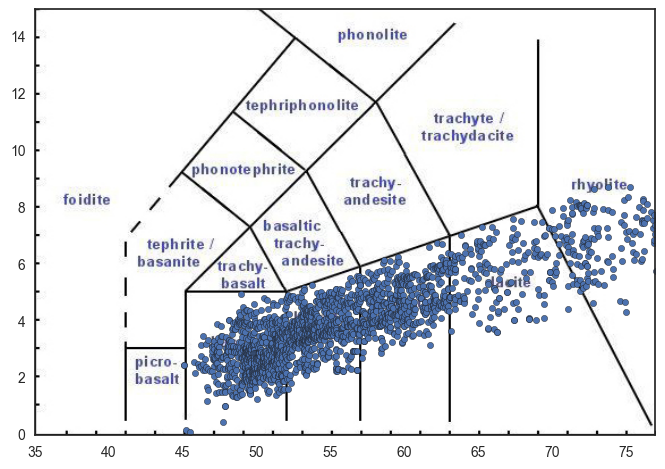

In [4]:
####### Removing alkaline samples
df = df.ix[(df['SIO2(WT%)']>45)]
df = df.ix[(df['NA2O(WT%)']+df['K2O(WT%)']<5) | (df['SIO2(WT%)']>52)]
a = (5-2)/(52-35)
b = 2-35*a
df = df.ix[(df['SIO2(WT%)']<52) | (df['NA2O(WT%)']+df['K2O(WT%)']<a*df['SIO2(WT%)']+b)]


###### TAS diagram
hor_ax = df['SIO2(WT%)']
vert_ax = df['K2O(WT%)'] + df['NA2O(WT%)']
im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\TAS diagram 77-15.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[35, 77, 0, 15], aspect='auto', cmap='gray')
ax.scatter(hor_ax, vert_ax)
ax.set(xlim=[35, 77], ylim=[0, 15])
plt.show()

## 2) Make SVM regressions

In [5]:
def make_ALR(dataframe, element):
    temp_df = pd.DataFrame()
    for index, Series in dataframe.iterrows():
        Series = Series.apply(lambda x: x/Series[element])
        Series = np.log(Series)
        temp_df = temp_df.append(Series)
        temp_df.drop(element, axis=1, inplace=True)
    return temp_df

In [6]:
#### creating x and y
X = df.loc[:, ['TIO2(WT%)', 'AL2O3(WT%)', 'Y(PPM)', 'ZR(PPM)',
               'NB(PPM)', 'LA(PPM)', 'CE(PPM)', 'SM(PPM)', 'YB(PPM)', 'TH(PPM)']]
X = make_ALR(X, 'YB(PPM)')
y1 = df['SIO2(WT%)']
df['Na2O+K2O(Wt%)'] = df['NA2O(WT%)'] + df['K2O(WT%)']
y2 = df['Na2O+K2O(Wt%)']

In [7]:
cv = KFold(n_splits=10, shuffle=True)

##### predicting SiO2 using cross-val_predict
SVM = make_pipeline(StandardScaler(), SVR(gamma=0.1, C=100, cache_size=2000))
df['SiO2_pred'] = cross_val_predict(SVM, X, y1, cv=cv, n_jobs=3)

##### predicting SiO2 using cross-val_predict
SVM = make_pipeline(StandardScaler(), SVR(gamma=0.1, C=10, cache_size=2000))
df['Na2O+K2O_pred'] = cross_val_predict(SVM, X, y2, cv=cv, n_jobs=3)

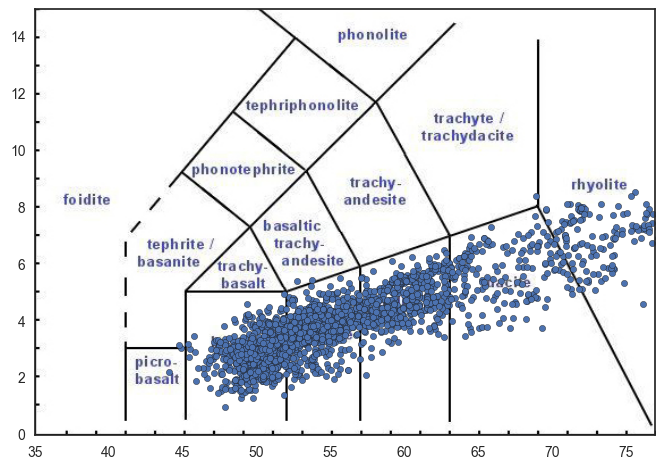

In [8]:
###### TAS diagram
hor_ax = df['SiO2_pred']
vert_ax = df['Na2O+K2O_pred']
im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\TAS diagram 77-15.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[35, 77, 0, 15], aspect='auto', cmap='gray')
ax.scatter(hor_ax, vert_ax)
ax.set(xlim=[35, 77], ylim=[0, 15])
plt.show()

## 3) Plot use results to classify TAS rock names and compare with analysis

In [9]:
###### Classify samples (from analysis)
def f_analysis(row):
    if row['SIO2(WT%)']<52:
        row['Rock_type_TAS']='basalt'
    elif row['SIO2(WT%)']<57:
        row['Rock_type_TAS']='basaltic-andesite'
    elif row['SIO2(WT%)']<63:
        row['Rock_type_TAS']='andesite'
    elif row['SIO2(WT%)'] + row['NA2O(WT%)'] + row['K2O(WT%)'] < 77:
        row['Rock_type_TAS']='dacite'
    else:
        row['Rock_type_TAS']='rhyolite'
    return row
df = df.apply(f_analysis, axis=1)

###### Classify samples (from prediction)
def f_analysis(row):
    if row['SiO2_pred']<52:
        row['Rock_type_pred']='basalt'
    elif row['SiO2_pred']<57:
        row['Rock_type_pred']='basaltic-andesite'
    elif row['SiO2_pred']<63:
        row['Rock_type_pred']='andesite'
    elif row['SiO2_pred'] + row['Na2O+K2O_pred'] < 77:
        row['Rock_type_pred']='dacite'
    else:
        row['Rock_type_pred']='rhyolite'
    return row
df = df.apply(f_analysis, axis=1)

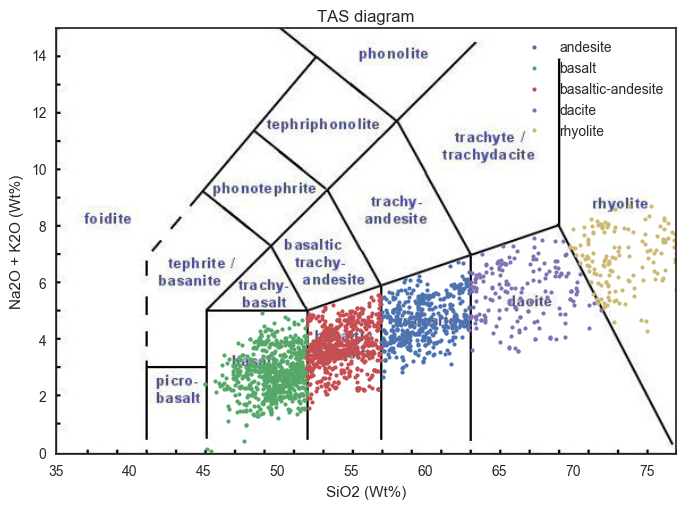

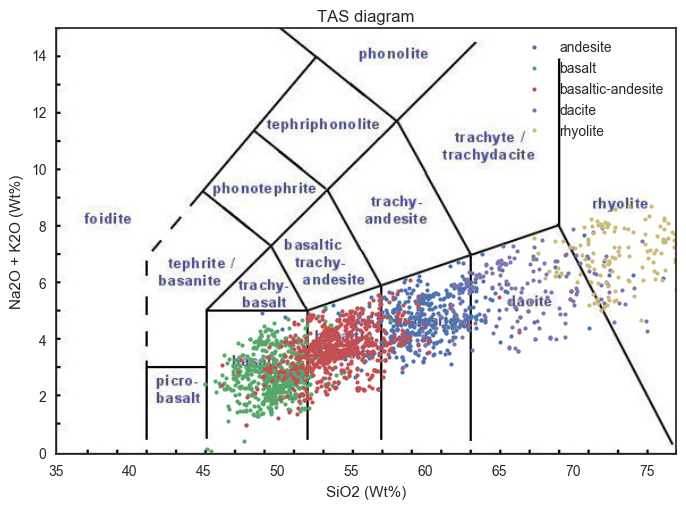

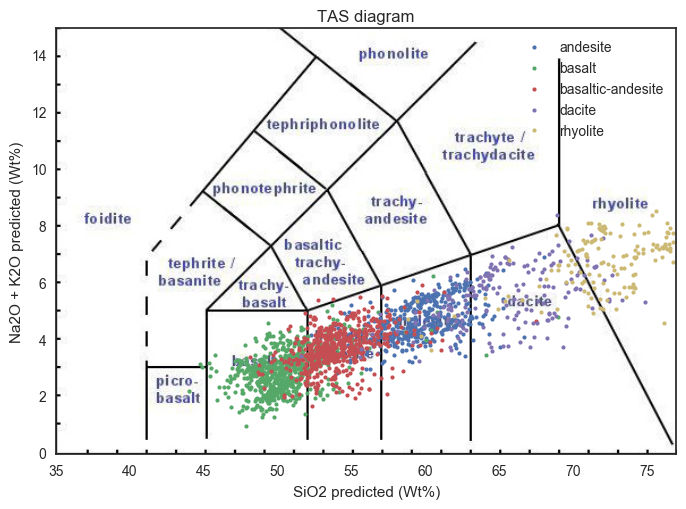

In [10]:
###### TAS diagram plotting real rock type using analyses
groups = df.groupby('Rock_type_TAS')
im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\TAS diagram 77-15.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[35, 77, 0, 15], aspect='auto', cmap='gray')
for name, group in groups:
    ax.plot(group['SIO2(WT%)'], group['Na2O+K2O(Wt%)'], marker='o', linestyle='', ms=3, label=name)
ax.legend()
ax.set(xlim=[35, 77], ylim=[0, 15], title='TAS diagram', xlabel='SiO2 (Wt%)', ylabel='Na2O + K2O (Wt%)')
plt.show()

###### TAS diagram plotting predicted rock type using analyses
groups = df.groupby('Rock_type_pred')
im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\TAS diagram 77-15.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[35, 77, 0, 15], aspect='auto', cmap='gray')
for name, group in groups:
    ax.plot(group['SIO2(WT%)'], group['Na2O+K2O(Wt%)'], marker='o', linestyle='', ms=3, label=name)
ax.legend()
ax.set(xlim=[35, 77], ylim=[0, 15], title='TAS diagram', xlabel='SiO2 (Wt%)', ylabel='Na2O + K2O (Wt%)')
plt.show()

###### TAS diagram plotting real rock type using predicted concentrations
groups = df.groupby('Rock_type_TAS')
im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\TAS diagram 77-15.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[35, 77, 0, 15], aspect='auto', cmap='gray')
for name, group in groups:
    ax.plot(group['SiO2_pred'], group['Na2O+K2O_pred'], marker='o', linestyle='', ms=3, label=name)
ax.legend()
ax.set(xlim=[35, 77], ylim=[0, 15], title='TAS diagram', xlabel='SiO2 predicted (Wt%)', ylabel='Na2O + K2O predicted (Wt%)')
plt.show()

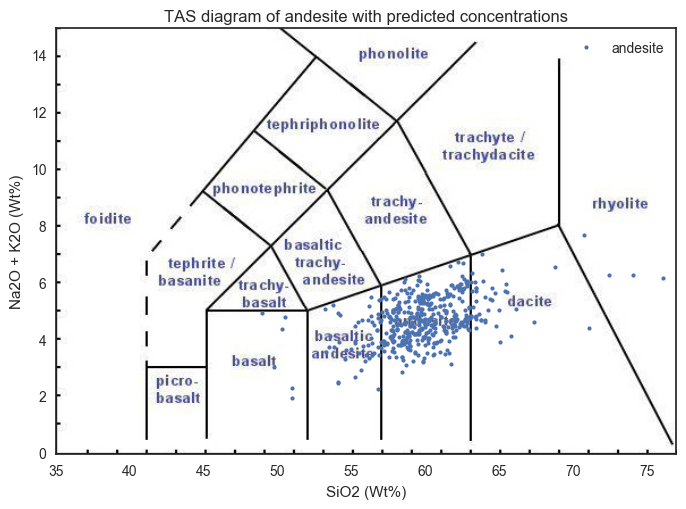

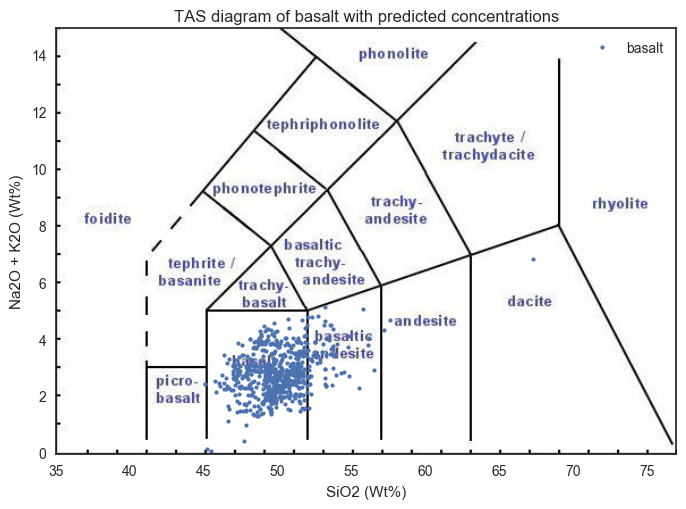

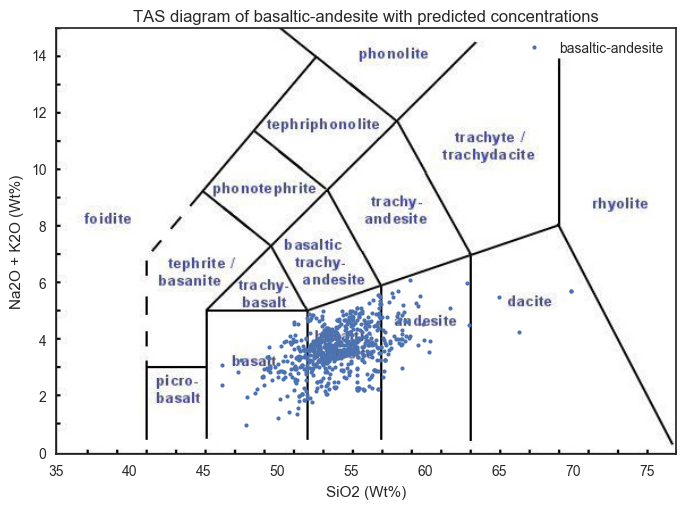

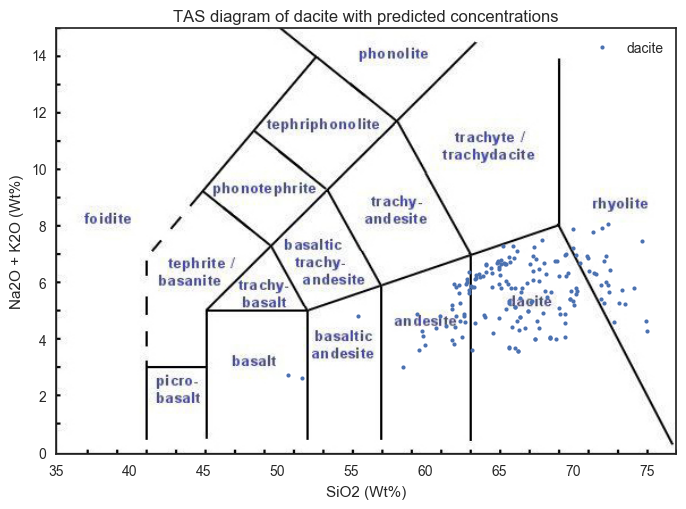

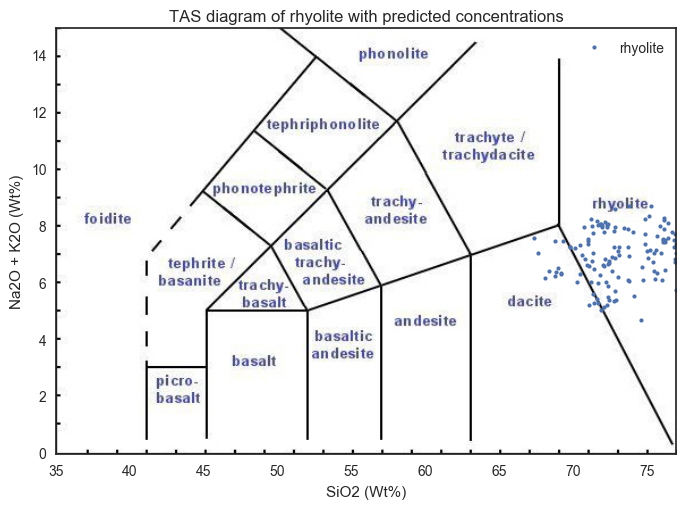

In [11]:
###### TAS diagram plotting predicted rock type using analyses
groups = df.groupby('Rock_type_pred')
im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\TAS diagram 77-15.jpg'))
for name, group in groups:
    fig, ax = plt.subplots()
    ax.imshow(im, extent=[35, 77, 0, 15], aspect='auto', cmap='gray')
    ax.plot(group['SIO2(WT%)'], group['Na2O+K2O(Wt%)'], marker='o', linestyle='', ms=3, label=name)
    ax.legend()
    ax.set(xlim=[35, 77], ylim=[0, 15], title='TAS diagram of ' + name + ' with predicted concentrations', xlabel='SiO2 (Wt%)', ylabel='Na2O + K2O (Wt%)')
    plt.show()

In [12]:
List_litho = df['Rock_type_TAS'].unique()
#### Classification report
print(classification_report(df['Rock_type_TAS'], df['Rock_type_pred'],
                            labels=List_litho, target_names=List_litho))

#### Confusion matrix
conf_mat = confusion_matrix(df['Rock_type_TAS'], df['Rock_type_pred'], labels= List_litho)
conf_mat = pd.DataFrame(conf_mat, columns=List_litho, index=List_litho)
conf_mat.head(10)

                   precision    recall  f1-score   support

           basalt       0.89      0.83      0.86       709
basaltic-andesite       0.73      0.80      0.76       597
         andesite       0.78      0.80      0.79       465
           dacite       0.63      0.63      0.63       176
         rhyolite       0.89      0.77      0.83       164

      avg / total       0.80      0.79      0.80      2111



,basalt,basaltic-andesite,andesite,dacite,rhyolite
basalt,587,114,6,2,0
basaltic-andesite,69,480,47,1,0
andesite,2,61,371,31,0
dacite,1,4,44,111,16
rhyolite,0,0,5,32,127


## 4) Winchester and Floy diagram

In [13]:
###### Classify samples into Winch and Floyd categories (from analysis)
def f_analysis_Winch(row):
    if row['SIO2(WT%)']<52:
        row['Rock_type_WinchFromTAS']='basalt'
    elif row['SIO2(WT%)']<63:
        row['Rock_type_WinchFromTAS']='andesite_basaltic-andesite'
    else:
        row['Rock_type_WinchFromTAS']='dacite_rhyolite'
    return row
df = df.apply(f_analysis_Winch, axis=1)

C:\Anaconda\lib\site-packages\matplotlib\image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


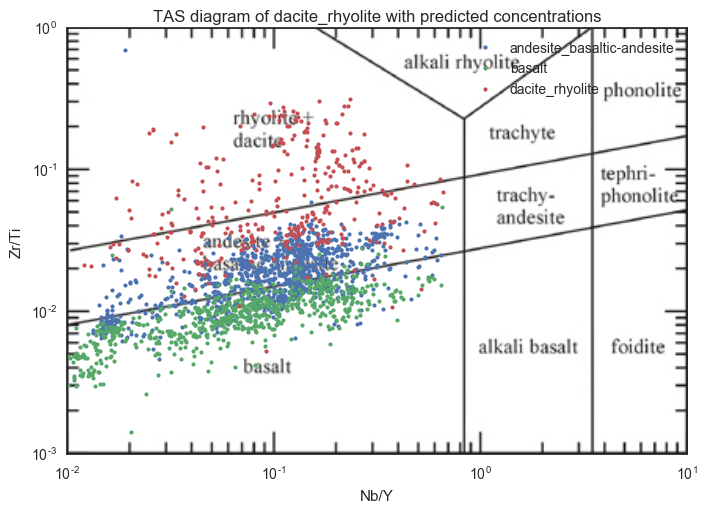

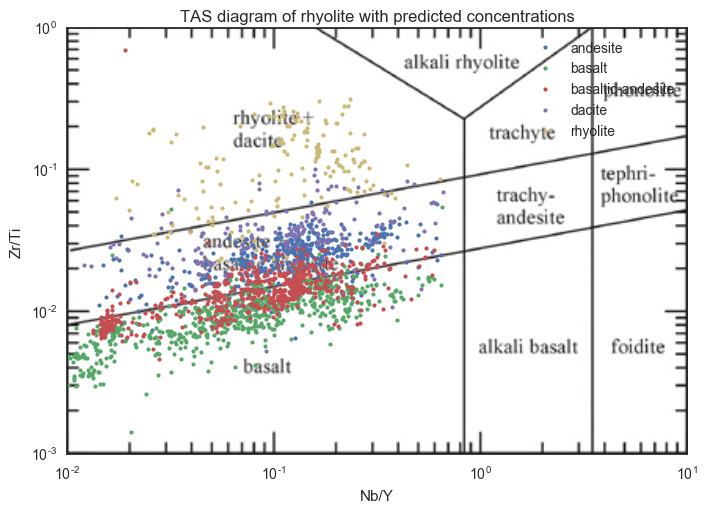

In [16]:
###### Winchester and Floyd diagram using simplified categories from TAS
groups = df.groupby('Rock_type_WinchFromTAS')

im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\Winch and Floyd by Pearce.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[0.01, 10, 0.001, 1], aspect='auto', cmap='gray')
for name, group in groups:
    ax.plot(group['NB(PPM)'] / group['Y(PPM)'],
            group['ZR(PPM)'] / (group['TIO2(WT%)']*10000/1.6681),
            marker='o', linestyle='', ms=3, label=name)
ax.set(xlim=[0.01, 10], ylim=[0.001, 1],
        title='TAS diagram of ' + name + ' with predicted concentrations',
       xlabel='Nb/Y', ylabel='Zr/Ti')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()


###### Winchester and Floyd diagram using categories from TAS
groups = df.groupby('Rock_type_TAS')

im = np.array(Image.open(r'C:\Users\Antoine Caté\Dropbox\Documents\Code\Geochem on python\Winch and Floyd by Pearce.jpg'))
fig, ax = plt.subplots()
ax.imshow(im, extent=[0.01, 10, 0.001, 1], aspect='auto', cmap='gray')
for name, group in groups:
    ax.plot(group['NB(PPM)'] / group['Y(PPM)'],
            group['ZR(PPM)'] / (group['TIO2(WT%)']*10000/1.6681),
            marker='o', linestyle='', ms=3, label=name)
ax.set(xlim=[0.01, 10], ylim=[0.001, 1],
        title='TAS diagram of ' + name + ' with predicted concentrations',
       xlabel='Nb/Y', ylabel='Zr/Ti')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()